## NXP Radar real Data Processing
#### Shengzhi Xu (s.xu-4@tudelft.nl)

### Import important packages

In [1]:
import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *
from scipy.io import loadmat
from scipy.signal import hann, hamming
from numpy.fft import fftshift, fft2, fft, ifft
from scipy.constants import speed_of_light as C
import h5py

from spatial_smoothing import spatial_smoothing
from polarplot import range_angle_polarplot
from angle_range_transfrom import angle_range_transfrom
% matplotlib inline

### Define some useful func and mpl setting

In [2]:
## utils
def normalizer(mat):
    max_value = np.max(mat)
    return mat - max_value

def eigsort(eigresult):
    """
    Sort the output of scipy.linalg.eig() in terms of
    eignevalue magnitude
    """
    ix = sp.argsort(abs(eigresult[0]))
    return ( eigresult[0][ix], eigresult[1][:,ix] )

def db(data):
    data = abs(data)
    data[data==0] = np.nan
    data = log10(data)
    data = data - min(data)
    data[data==np.nan] = 0
    return data

params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

### Load data and radar settings

In [3]:
slice = 999
fold = (slice//200)*200
path = 'BeatSignals/{}_{}/'.format(str(fold+1).zfill(4), str(fold+200).zfill(4))
file = '{}th_slice'.format(slice)        # 835

print('\nLoading Data and Parameters:')
f = loadmat(path+file)
DATA = f['Dat']
# DATA = np.squeeze(np.transpose(DATA, [4,3,2,1,0]))  # NTx, NRx, NSweep, NSamples

f = loadmat('Calibration.mat')
CAL = f['CAL']

SETTINGS = {}
with h5py.File('RadarSettings.mat') as f:
    for i in list(f['settings'].keys()):
        SETTINGS[i] = f['settings'][i].value[0, 0]
        SETTINGS['MIMO_coding_matrix'] = f['settings']['MIMO_coding_matrix'].value
        exec('{} = f[{}][{}].value[0,0]'.format(i, "'settings'","i"))
        print(i, ':'.ljust(10, ' '), f['settings'][i].value[0, 0])
        
print('\nData shape: {}'.format(DATA.shape))


Loading Data and Parameters:
BW :          1005539072.0
Chirp_time :          4.99999987369e-05
DecimationRate :          2.0
DwellTime :          9.99999997475e-07
Fc :          78819008512.0
FrameRate :          400.0
Fs :          20000000.0
MIMO_coding_matrix :          1.0
NChirps :          256.0
NRx :          4.0
NSamples :          512.0
NTx :          3.0
Reset_time :          4.99999987369e-06

Data shape: (3, 4, 256, 512)


### Constants setting

In [4]:
D = 1.889e-3
J = 2j*np.pi
E = np.e
LAMBDA = C/SETTINGS['Fc']
FD = D/LAMBDA

range_fft_number = 2048
doppler_fft_number = 1024
angle_fft_number = 128

# processing setting
save_fig = False
slow_time_cutoff = 16
cmap = plt.cm.jet

### Extended Parameters

In [5]:
range_resolution = C/2/SETTINGS['Fc']
mu = SETTINGS['BW']/(SETTINGS['Chirp_time'] - SETTINGS['DwellTime'] - SETTINGS['Reset_time'])
range_max = 0.5*(C * SETTINGS['Fs'] / 2 / mu)
velocity_max = 0.5 * C / 2 / SETTINGS['Chirp_time'] / SETTINGS['Fc']
unmigrate_velocity = C/2/SETTINGS['BW'] / SETTINGS['Chirp_time'] / SETTINGS['NChirps']
range_velocity_coupling_cof = mu/2/SETTINGS['Fc']/SETTINGS['Fs']
range_angle_coupling_cof = D*mu/SETTINGS['Fs']/C

print('Unambiguous Range is: {:.2f} meter.'.format(range_max))
print('Unambiguous velocity is {:.2f} m/s.'.format(velocity_max))
print('Migration velocity is {:.2f} m/s.'.format(unmigrate_velocity))
print('Range Velocity coupling coefficient is {:.2g}.'.format(range_velocity_coupling_cof))
print('Range Angle coupling coefficient is {:.2g}.'.format(range_angle_coupling_cof))

Unambiguous Range is: 65.59 meter.
Unambiguous velocity is 19.02 m/s.
Migration velocity is 11.65 m/s.
Range Velocity coupling coefficient is 7.2e-06.
Range Angle coupling coefficient is 7.2e-06.


### Remove Dwell/Settle/Reset Time Data

In [6]:
# remove dwell time, reset time, and settle time
settle_time = 4e-6
start_point = int(SETTINGS['NSamples']*(SETTINGS['DwellTime'] + settle_time)/SETTINGS['Chirp_time'])+1
end_point = np.int(SETTINGS['NSamples']-SETTINGS['NSamples']*SETTINGS['Reset_time']/SETTINGS['Chirp_time'])-1
data_beat_freq = DATA[:, :, :, start_point:end_point]

# remove direct wave
direct_wave_range = 3  # meter
direct_wave_fft_grids = int(direct_wave_range * range_fft_number/2 / range_max)
range_fft_data = fft(data_beat_freq, n=range_fft_number, axis=-1)[:,:,:, 0:range_fft_number//2]
range_fft_data_cutoff = range_fft_data[:,:,:, direct_wave_fft_grids::]

### Data Calibration

In [7]:
## Calibration
*num_virtue_array, num_slow_time, num_fft_fast_time = range_fft_data_cutoff.shape
virtual_array_data = range_fft_data_cutoff.reshape(12, num_slow_time, num_fft_fast_time)     # data:ttk
correction = np.transpose(np.tile(CAL, [num_slow_time, num_fft_fast_time, 1]), [2,0,1])
calibrated_data = virtual_array_data*correction                            # data:ttk   (12*256*978)

### 1D MUSIC for Range-Angle (Doppler as reference)

Here the number of target is decided by the $dynamic$ threshold:
$$T = 5\times mean(\sigma)$$
Spatial smoothing is applied here for coherent sources

For each range cell, the 1D MUSIC result is normalized by the range FT amplitude
$$P_r = \max(\sigma)\frac{P-\min(P)}{\max(P)-\min(P)}$$
where $P$ is the original music spectral and $\sigma$ is the singular value of range cell $r$


1D MUSIC processing for range-angle....
Time for 1D MUSIC: 1.27 seconds!


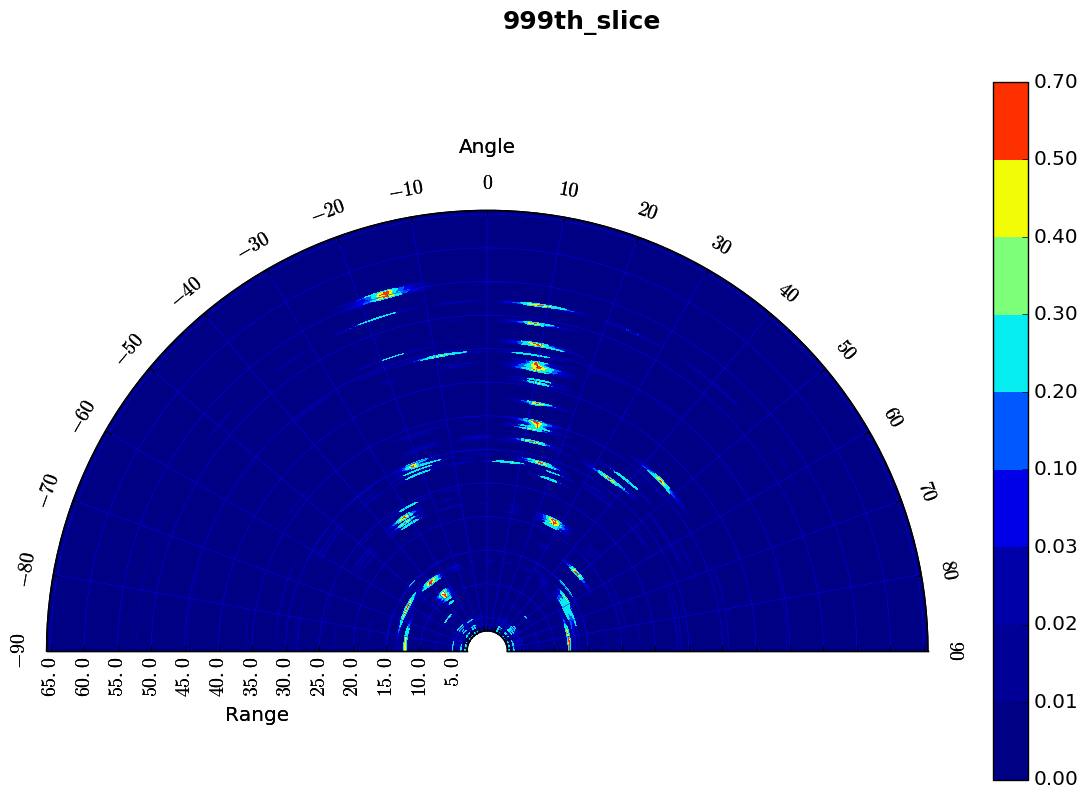

In [14]:
angle_music_number = 180
freq_bins_number = 200
angle_scan = linspace(-pi/2, pi/2, angle_music_number)
freq_domain = linspace(-0.5, 0.5, freq_bins_number)

Pmusic2 = np.zeros((len(angle_scan), num_fft_fast_time))
spectral_norm = np.zeros(num_fft_fast_time, dtype=complex)
print('\n1D MUSIC processing for range-angle....')
tic = time.time()
null_range = 0

derank_q, derank_p = 2, 2

music_1d_data = calibrated_data[:, 0:slow_time_cutoff, :]   # ttk
# amplitude_extraction = fft(music_1d_data, axis=1, n=doppler_fft_number)
for i in range(num_fft_fast_time):
#    print(i)
    tmp = music_1d_data[:, :, i]    ## tt
    if derank_p|derank_q:
        R = spatial_smoothing(tmp).spatial_smoothing(derank_q=derank_q, derank_p=derank_p)
    else:
        R = tmp.dot(tmp.T.conj())
    eigval, eigvec = eigsort(np.linalg.eig(R))

    threshold = mean(eigval) * 4
    num_targets = sum(eigval >= threshold)
    if num_targets == 0:
        null_range = null_range+1
        continue
    elif num_targets >= 2:
        print('target number for range{}: {}'.format(i, num_targets))
    else:
        pass
    noise_subspace = eigvec[:, 0:R.shape[0]-num_targets]
    spectral_norm[i] = max(eigval)

    for j, a in enumerate(angle_scan):
        steering =  E**(-J*FD*sin(a)*np.arange(R.shape[0])).reshape((1, R.shape[0]))
        p = (abs(steering.dot(noise_subspace).dot(noise_subspace.T.conj()).dot(steering.T.conj())))
        Pmusic2[j, i] = 1/p[0, 0]
    [ta, ti] = [np.max(Pmusic2[:, i]), np.min(Pmusic2[:, i])]
    Pmusic2[:,i] = (((Pmusic2[:, i] - ti + 0.00001)/(ta-ti)) * (spectral_norm[i].real)**(1/8))

print('Time for 1D MUSIC: {:.2f} seconds!'.format(time.time() - tic))

fig = plt.figure(figsize=[14.5, 9])
levels_polarplot = [0, 0.01, 0.02, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
pic = range_angle_polarplot(fig=fig, data=(Pmusic2[:, 0::]), rmax=range_max,
                      rmin=direct_wave_range).polar_plot(levels=levels_polarplot, cmap=cmap, title=file)

### FFT Processing for Range-Angle

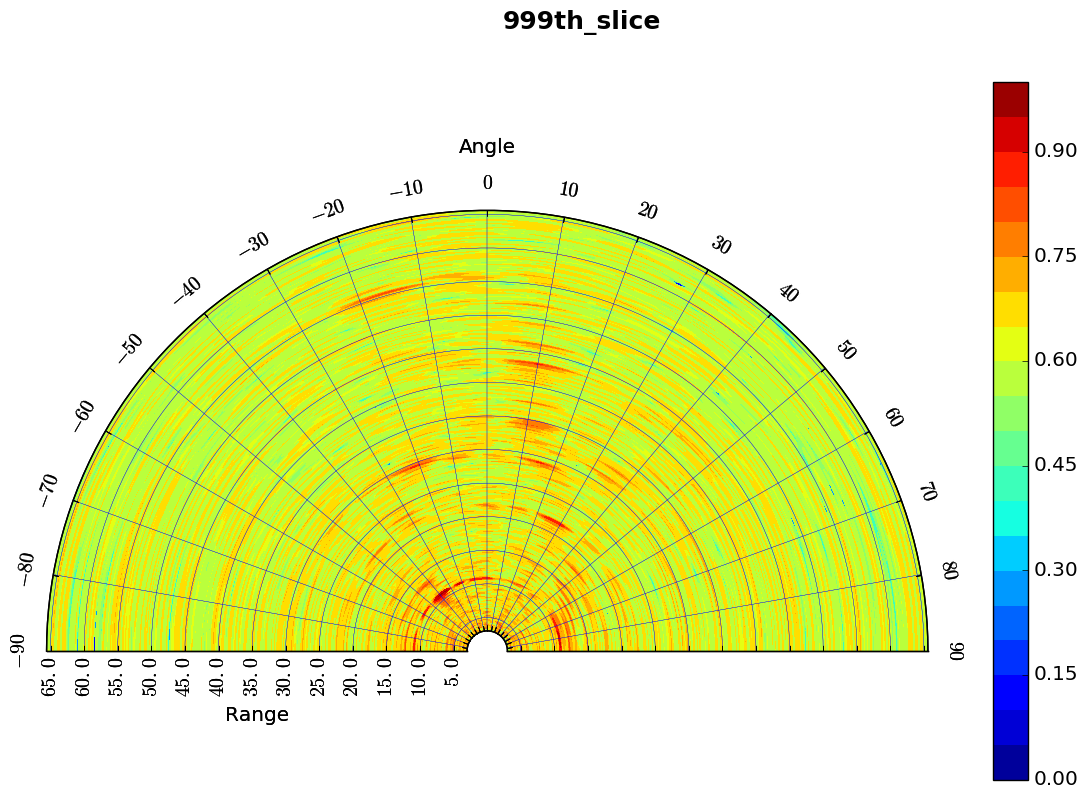

In [9]:
## AR FFT
# reshape and calibration
fad = fftshift(fft(calibrated_data, n=angle_fft_number, axis=0), axes=0)
del virtual_array_data, correction

# plot
absolute_fad = 10*log10(abs(fad))
pic = absolute_fad[:, 0, :]
new_pic = angle_range_transfrom(pic.T, rmin=direct_wave_range, rmax=range_max,
                                angle_min=-pi/2, angle_max=pi/2).sine_to_degree()
fig = plt.figure(figsize=[14.5, 9])
range_angle_polarplot(fig=fig, data=new_pic.T, rmax=range_max, rmin=direct_wave_range).polar_plot(cmap=cmap, title=file)

### The Real Scene

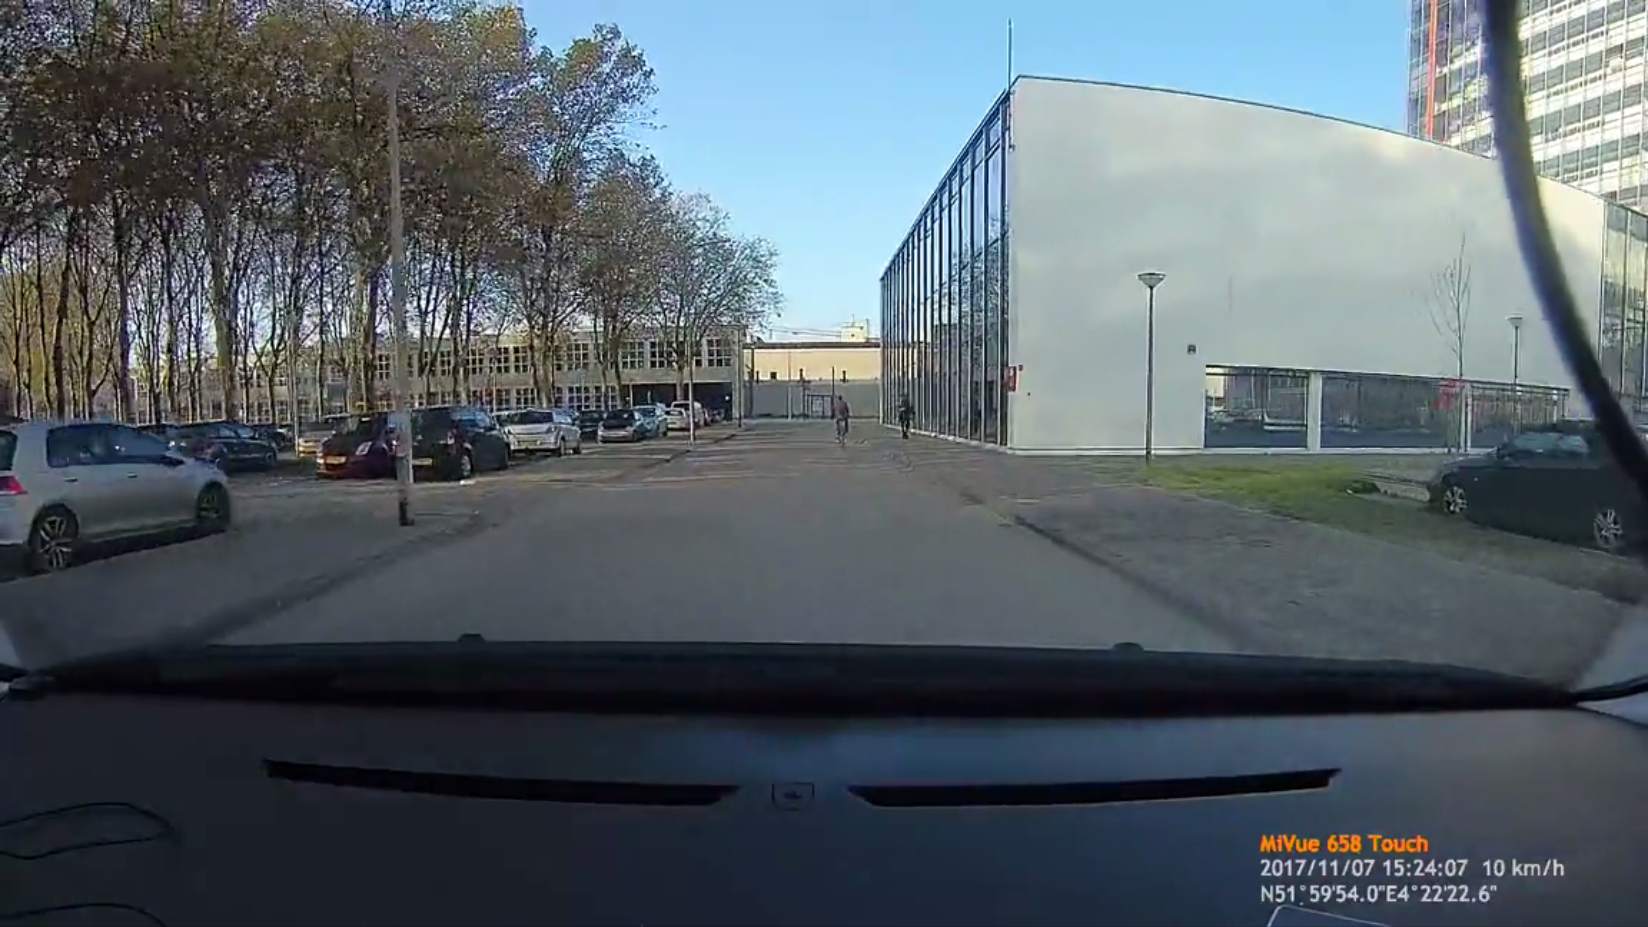

In [10]:
#![Camera](999sliceS.png)
from IPython.display import Image
Image("999sliceS.png")

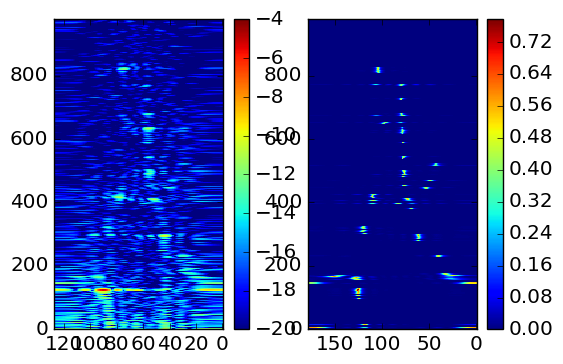

In [39]:
fig = figure()
fig.add_subplot(121)
pic = plt.imshow(new_pic, interpolation='Nearest')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.gca().set_aspect('auto')
plt.colorbar()
pic.set_clim(vmin=-20, vmax=-4)

fig.add_subplot(122)
pic = plt.imshow(Pmusic2.T, interpolation='Nearest')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.gca().set_aspect('auto')
plt.colorbar()
# pic.set_clim(vmin=-20, vmax=-4)

In [32]:
Pmusic2.shape

(180, 978)